In [1]:
import pandas as pd
from bertopic import BERTopic
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
import plotly.express as px

filter_relevant_features = True
shap_threshold = 0.001

bert_min_topic_size = 3

C:\Users\lucas\anaconda3\envs\bertopic\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("feature_importance_shap_lgb.csv", sep=";")

In [3]:
df = df[~df["description"].isna()].reset_index(drop=True)
# df["description"] = df["description"].fillna("NA")

In [4]:
df.head()

,Unnamed: 0,feature,shap_value,gene_info,title,status,description
0,127,EGFR,0.113644,"{'phenotypes': [{'mimNumber': 131550, 'phenoty...",EPIDERMAL GROWTH FACTOR RECEPTOR; EGFR,live,EGFR and its ligands are cell signaling molecu...
1,284,KRAS,0.084045,"{'phenotypes': [{'mimNumber': 190070, 'phenoty...","KRAS PROTOONCOGENE, GTPase; KRAS",live,The KRAS gene encodes the human cellular homol...
2,182,FLT1,0.058932,"{'phenotypes': [], 'allelicVariants': [], 'mim...",FMS-RELATED TYROSINE KINASE 1; FLT1,live,Oncogene FLT belongs to the src gene family an...
3,406,PTEN,0.057816,"{'phenotypes': [{'mimNumber': 601728, 'phenoty...",PHOSPHATASE AND TENSIN HOMOLOG; PTEN,live,The PTEN gene encodes a ubiquitously expressed...
4,440,ROS1,0.056212,"{'phenotypes': [], 'allelicVariants': [], 'mim...","ROS PROTOONCOGENE 1, RECEPTOR TYROSINE KINASE;...",live,"ROS1, the human homolog of the transforming ge..."


In [5]:
df["shap_value"].describe()

count    513.000000
mean       0.003304
std        0.009637
min        0.000000
25%        0.000000
50%        0.000000
75%        0.002029
max        0.113644
Name: shap_value, dtype: float64

<AxesSubplot: >

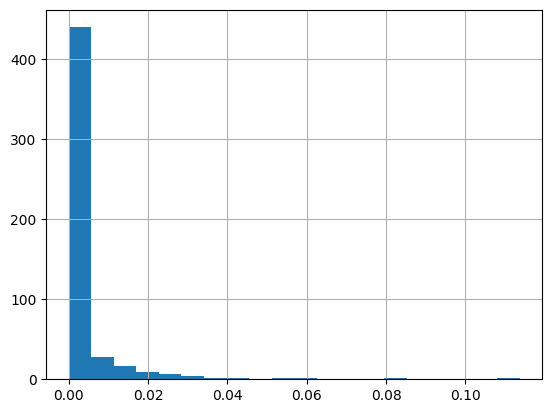

In [6]:
df["shap_value"].hist(bins=20)

In [7]:
if filter_relevant_features:
    df = df[df["shap_value"]>=shap_threshold].reset_index(drop=True)

In [8]:
len(df)

159

In [9]:
stopwords = stopwords.words('english')
stopwords = stopwords+["et", "al", "http", "href", "omim", "org"]

In [10]:
df["description_clean"] = df["description"].str.lower().str.replace('[^a-zA-Z]', ' ')
df["description_clean"] = df["description_clean"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [11]:
docs = []
for case in df["description_clean"]:
    docs.append(case)

In [12]:
len(docs)

159

In [13]:
docs[0]

'egfr ligands cell signaling molecules involved diverse cellular functions including cell proliferation differentiation motility survival tissue development wang'

In [14]:
topic_model = BERTopic(min_topic_size=bert_min_topic_size)
topics, probs = topic_model.fit_transform(docs)

In [15]:
len(probs)

159

In [16]:
df["topic"] = topics

In [17]:
df["topic"].value_counts()

-1     48
 0     15
 2     11
 1     11
 3     10
 4     10
 5      8
 6      7
 8      6
 7      6
 9      6
 10     5
 11     5
 13     4
 12     4
 14     3
Name: topic, dtype: int64

In [18]:
df_topic_model = topic_model.get_topic_info()

In [46]:
topic_model.visualize_barchart(n_words=10, height=600)

In [21]:
topic_model.get_representative_docs(0)

['phosphoinositides pis lipid molecules play crucial roles diverse cellular functions pis produced response specific stimuli recruit binding proteins particular intracellular sites proteins exert function pis interconverted phosphorylation dephosphorylation pi kinases pi phosphatases respectively pik c b beta isoform class ii pi kinase pi k thought produce phosphatidylinositol phosphate ptdins p phosphatidylinositol bisphosphate ptdins p summary maehama',
 'phosphatidylinositol kinase pi k lipid kinase phosphorylates inositol ring phosphatidylinositol related compounds prime position products reactions thought serve second messengers growth signaling pathways kinase made catalytic subunit molecular mass kd p e g pik ca entry regulatory subunit often molecular mass kd p pik r summary hoyle',
 'protein tyrosine phosphatases highly pleomorphic set molecules role regulating responses eukaryotic cells extracellular signals dechert achieve regulating phosphotyrosine content specific intracel

In [22]:
topic_model.visualize_topics()

In [23]:
topic_model.visualize_heatmap()

In [24]:
topic_model.visualize_term_rank()

In [25]:
hierarchical_topics = topic_model.hierarchical_topics(docs)

100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 297.86it/s]


In [26]:
hierarchical_topics

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
13,28,entry_gene_protein_human_kinase,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",25,human_sequence_gene_protein_cdna,27,entry_dna_see_gene_protein,1.969148
12,27,entry_dna_see_gene_protein,"[0, 1, 3, 4, 6, 8, 10, 11, 12, 14]",22,entry_kinase_tyrosine_receptor_pik,26,dna_entry_repair_gene_ercc,1.629858
11,26,dna_entry_repair_gene_ercc,"[1, 3, 4, 6, 11, 12, 14]",24,entry_repair_ercc_dna_recql,21,chromatin_histone_remodeling_gene_transcriptional,1.471299
10,25,human_sequence_gene_protein_cdna,"[2, 5, 7, 9, 13]",7,ras_virus_sarcoma_transforming_nras,18,human_sequence_protein_cdna_gene,1.328980
9,24,entry_repair_ercc_dna_recql,"[1, 4, 11, 12]",11,ubiquitin_ligase_tnf_degradation_mediated,23,entry_repair_ercc_dna_recql,1.316362
8,23,entry_repair_ercc_dna_recql,"[1, 4, 12]",19,entry_ercc_dna_repair_recql,12,brca_brip_checkpoint_helicase_stability,1.281711
7,22,entry_kinase_tyrosine_receptor_pik,"[0, 8, 10]",10,ntrk_jak_neurotrophic_family_background,17,pik_entry_receptors_kinase_tyrosine,1.225848
6,21,chromatin_histone_remodeling_gene_transcriptional,"[3, 6, 14]",20,histone_chromatin_methylation_remodeling_gene,14,wt_formation_finger_zinc_repressor,1.200260
5,20,histone_chromatin_methylation_remodeling_gene,"[3, 6]",6,remodeling_swi_dicer_chromatin_snf,3,histone_methylation_methyltransferase_tet_deme...,1.188983
4,19,entry_ercc_dna_repair_recql,"[1, 4]",1,ercc_repair_recql_entry_dna,4,card_entry_dna_cdkn_protein,1.136551


In [27]:
print(topic_model.get_topic_tree(hierarchical_topics))

.
├─human_sequence_gene_protein_cdna
│    ├─■──ras_virus_sarcoma_transforming_nras ── Topic: 7
│    └─human_sequence_protein_cdna_gene
│         ├─sequence_gene_cdna_human_amino
│         │    ├─■──receptor_hgf_kinase_entry_tyrosine ── Topic: 2
│         │    └─amino_sequence_gene_brca_acid
│         │         ├─■──lats_gene_amino_sequence_mouse ── Topic: 5
│         │         └─■──brca_raf_sequence_cdna_amino ── Topic: 13
│         └─■──pms_crm_yeast_human_setbp ── Topic: 9
└─entry_dna_see_gene_protein
     ├─entry_kinase_tyrosine_receptor_pik
     │    ├─■──ntrk_jak_neurotrophic_family_background ── Topic: 10
     │    └─pik_entry_receptors_kinase_tyrosine
     │         ├─■──entry_notch_growth_factor_receptors ── Topic: 8
     │         └─■──pik_pi_ptpases_kinase_phosphatidylinositol ── Topic: 0
     └─dna_entry_repair_gene_ercc
          ├─entry_repair_ercc_dna_recql
          │    ├─■──ubiquitin_ligase_tnf_degradation_mediated ── Topic: 11
          │    └─entry_repair_ercc_dna_re

In [28]:
topic_model.visualize_hierarchy()

In [39]:
v = TfidfVectorizer()
x = v.fit_transform(df['description_clean'])
df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
tf_idf_words = df1.columns
df = pd.concat([df, df1], axis=1)

scaler = StandardScaler()
scaler_fit = scaler.fit(df1.values) 
df_scaled = scaler_fit.transform(df1.values)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = tf_idf_words

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_scaled)
embedding.shape

df["UMAP_X"] = embedding[:, 0]
df["UMAP_Y"] = embedding[:, 1]

df["topic_bert"] = df["topic"].astype(int).astype(str)

In [38]:
fig = px.scatter(df, x="UMAP_X", y="UMAP_Y", color="topic_bert"#, hover_data=['feature']
                 )
fig.show()